In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from scipy import linalg
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [12]:
df = pd.read_csv("heart.csv")

# **XGBoost**

In [13]:
try:
    from xgboost import XGBClassifier
    use_xgb = True
except ImportError:
    use_xgb = False

In [14]:
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
target_col = 'target'
numerical_cols = [col for col in df.columns if col not in categorical_cols + [target_col]]

for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)
df[target_col].fillna(df[target_col].mode()[0], inplace=True)

Оригинальные данные после импутации

In [15]:
df_original = df.copy()

Min-Max Normalization

In [16]:
df_minmax = df.copy()
minmax_scaler = MinMaxScaler()
df_minmax[numerical_cols] = minmax_scaler.fit_transform(df_minmax[numerical_cols])

Standardization

In [17]:
df_std = df.copy()
standard_scaler = StandardScaler()
df_std[numerical_cols] = standard_scaler.fit_transform(df_std[numerical_cols])

Box-Cox + Frequency Encoding

In [ ]:
df_bc = df.copy()
pt = PowerTransformer(method='yeo-johnson')
df_bc[numerical_cols] = pt.fit_transform(df_bc[numerical_cols])
for col in categorical_cols:
    freqs = df_bc[col].value_counts(normalize=True)
    df_bc[col + "_freq"] = df_bc[col].map(freqs)
df_bc.drop(columns=categorical_cols, inplace=True)

Vizualisation

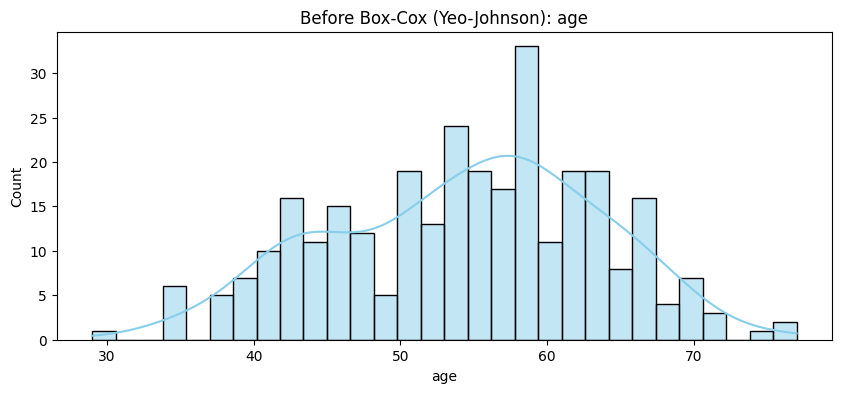

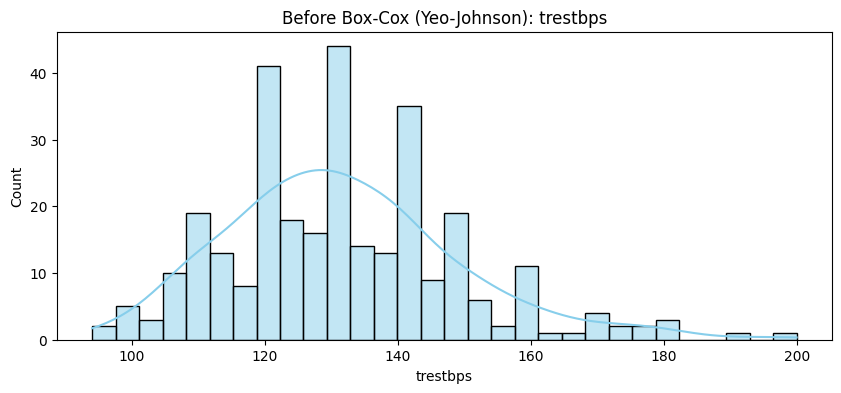

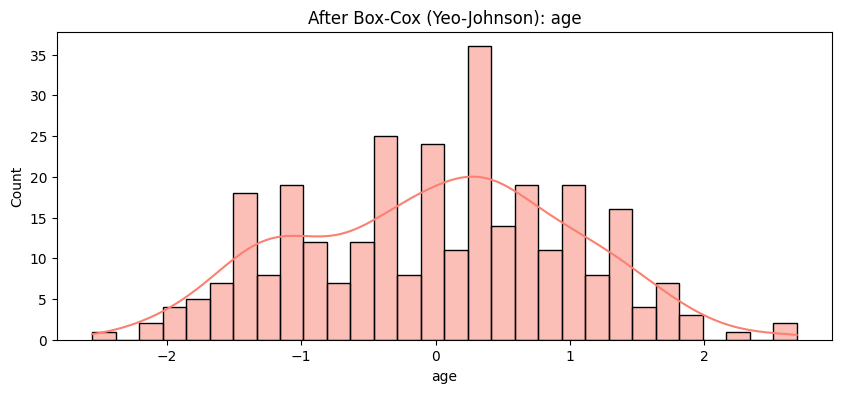

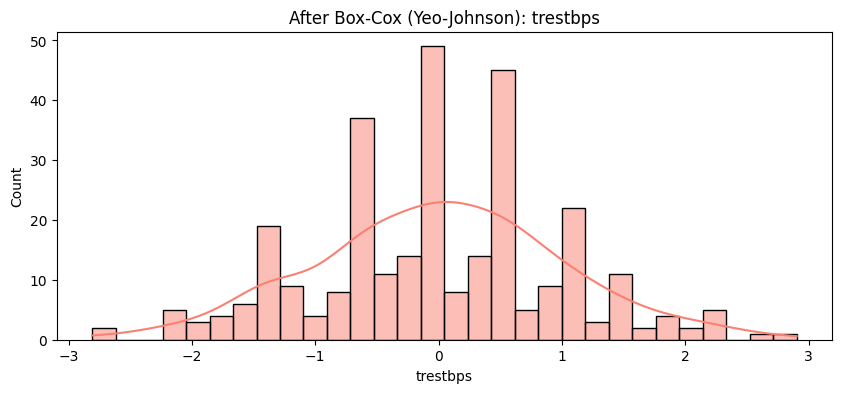

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

df_bc = df.copy()
pt = PowerTransformer(method='yeo-johnson')

#Before
sample_num_cols = numerical_cols[:2]  # 2 числовых признака
for col in sample_num_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(df_bc[col], kde=True, bins=30, color='skyblue')
    plt.title(f"Before Box-Cox (Yeo-Johnson): {col}")
    plt.show()

# Преобразование
df_bc[numerical_cols] = pt.fit_transform(df_bc[numerical_cols])

#After
for col in sample_num_cols:
    plt.figure(figsize=(10, 4))
    sns.histplot(df_bc[col], kde=True, bins=30, color='salmon')
    plt.title(f"After Box-Cox (Yeo-Johnson): {col}")
    plt.show()


ZCA Whitening

In [20]:
def zca_whitening(X):
    sigma = np.cov(X, rowvar=False)
    U, S, _ = linalg.svd(sigma)
    epsilon = 1e-5
    ZCA_matrix = U @ np.diag(1.0 / np.sqrt(S + epsilon)) @ U.T
    return X @ ZCA_matrix
df_zca = df_std.copy()
df_zca[numerical_cols] = zca_whitening(df_std[numerical_cols])

In [21]:
datasets = {
    "Original": df_original,
    "MinMax": df_minmax,
    "Standardized": df_std,
    "ZCA": df_zca,
    "BoxCox+FreqEnc": df_bc
}

Определение моделей

In [22]:
models = {
    "LogReg": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier()
}
if use_xgb:
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# **до Feature Engineering**

In [23]:
df_baseline = df_original.copy()
X_base = df_baseline.drop(columns=[target_col])
y_base = df_baseline[target_col]
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, stratify=y_base, test_size=0.2, random_state=42)

baseline_results = []

for model_name, model in models.items():
    model.fit(X_train_base, y_train_base)
    train_preds = model.predict(X_train_base)
    test_preds = model.predict(X_test_base)

    train_probs = model.predict_proba(X_train_base)[:, 1] if hasattr(model, 'predict_proba') else train_preds
    test_probs = model.predict_proba(X_test_base)[:, 1] if hasattr(model, 'predict_proba') else test_preds

    acc_train = accuracy_score(y_train_base, train_preds)
    acc_test = accuracy_score(y_test_base, test_preds)
    f1 = f1_score(y_test_base, test_preds)
    auc = roc_auc_score(y_test_base, test_probs)
    overfit = round(acc_train - acc_test, 3)

    baseline_results.append({
        "Phase": "Before_FE",
        "Dataset": "Baseline",
        "Model": model_name,
        "Train_Acc": round(acc_train, 3),
        "Test_Acc": round(acc_test, 3),
        "F1": round(f1, 3),
        "ROC_AUC": round(auc, 3),
        "Overfit_Score": overfit
    })

# **После Feature Engineering**

In [24]:
fe_results = []

for name, df_data in datasets.items():
    X = df_data.drop(columns=[target_col])
    y = df_data[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    for model_name, model in models.items():
        model.fit(X_train, y_train)
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)

        train_probs = model.predict_proba(X_train)[:, 1] if hasattr(model, 'predict_proba') else train_preds
        test_probs = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else test_preds

        acc_train = accuracy_score(y_train, train_preds)
        acc_test = accuracy_score(y_test, test_preds)
        f1 = f1_score(y_test, test_preds)
        auc = roc_auc_score(y_test, test_probs)

        overfit_score = round(acc_train - acc_test, 3)

        fe_results.append({
            "Phase": "After_FE",
            "Dataset": name,
            "Model": model_name,
            "Train_Acc": round(acc_train, 3),
            "Test_Acc": round(acc_test, 3),
            "F1": round(f1, 3),
            "ROC_AUC": round(auc, 3),
            "Overfit_Score": overfit_score
        })

# **Объединение и анализ**

In [26]:
df_all = pd.DataFrame(baseline_results + fe_results)


pivot_acc = df_all.pivot_table(index=["Dataset", "Phase"], columns="Model", values="Test_Acc")
print("=== Сравнение Test Accuracy до и после Feature Engineering ===")
print(pivot_acc)

=== Сравнение Test Accuracy до и после Feature Engineering ===
Model                       KNN  LogReg  RandomForest  XGBoost
Dataset        Phase                                          
Baseline       Before_FE  0.590   0.803         0.836    0.803
BoxCox+FreqEnc After_FE   0.787   0.770         0.836    0.803
MinMax         After_FE   0.803   0.787         0.820    0.803
Original       After_FE   0.590   0.803         0.803    0.803
Standardized   After_FE   0.787   0.803         0.803    0.803
ZCA            After_FE   0.803   0.803         0.803    0.820


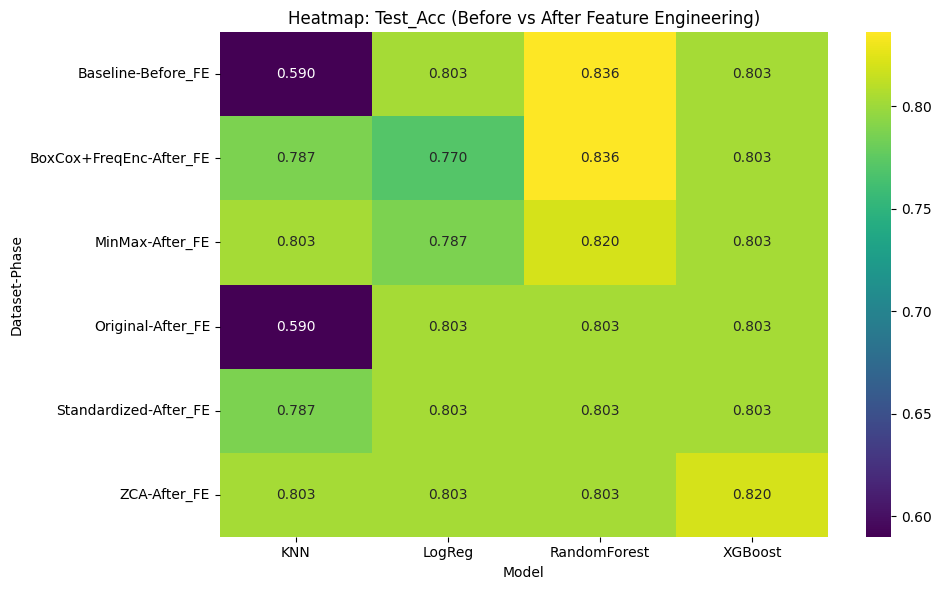

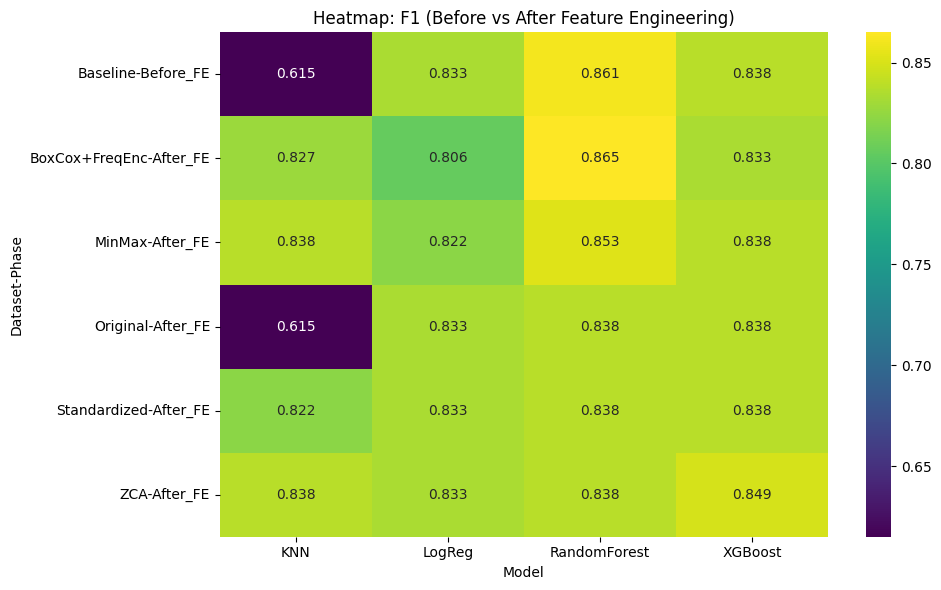

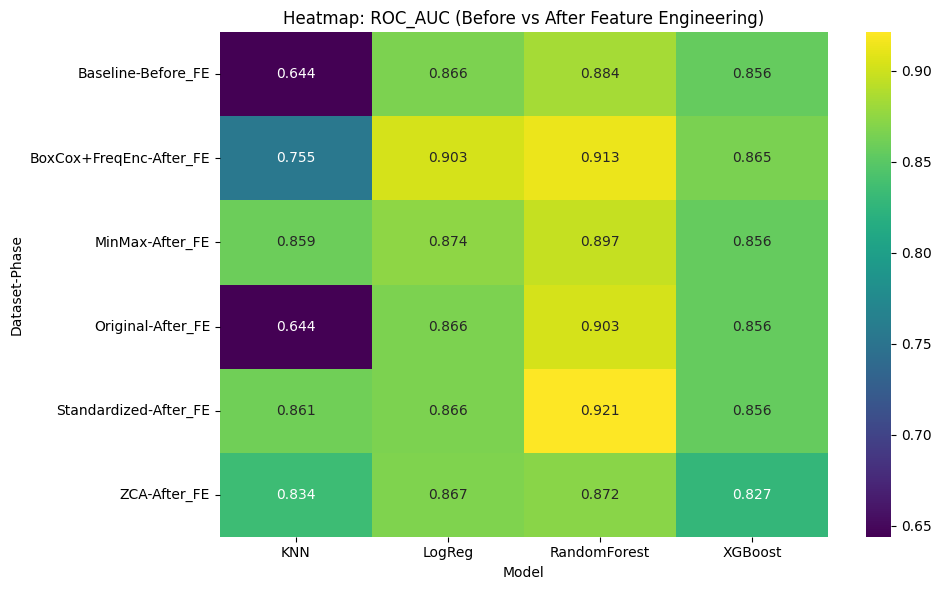

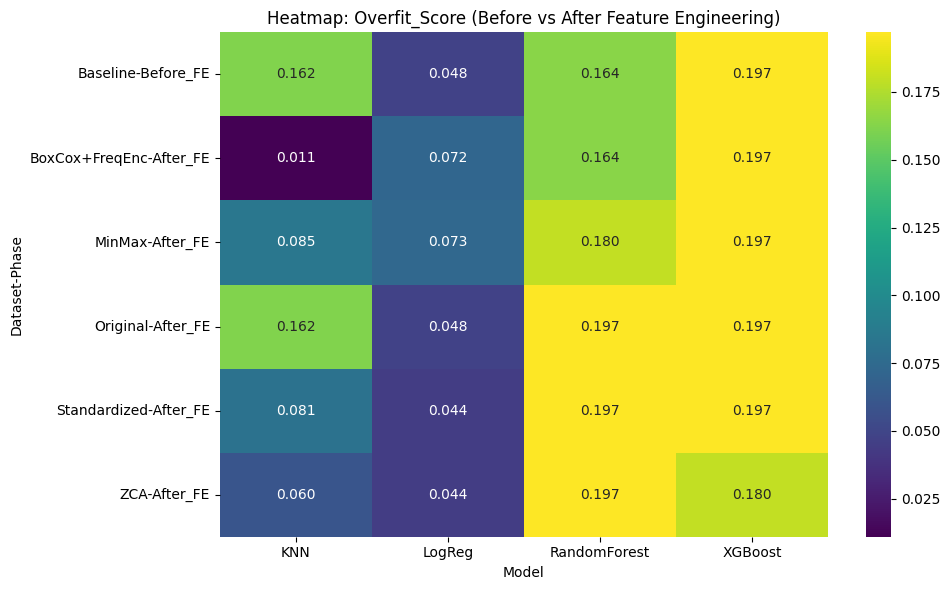

In [27]:
for metric in ["Test_Acc", "F1", "ROC_AUC", "Overfit_Score"]:
    pivot = df_all.pivot(index=["Dataset", "Phase"], columns="Model", values=metric)
    plt.figure(figsize=(10, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis", cbar=True)
    plt.title(f"Heatmap: {metric} (Before vs After Feature Engineering)")
    plt.tight_layout()
    plt.show()

# Топ_5 моделей после Feature Engineering


In [28]:
best_models = df_all[df_all['Phase'] == 'After_FE'].sort_values(by='Test_Acc', ascending=False)
print("\n=== ТОП-5 моделей после Feature Engineering по Test Accuracy ===")
print(best_models.head(5))


=== ТОП-5 моделей после Feature Engineering по Test Accuracy ===
       Phase         Dataset         Model  Train_Acc  Test_Acc     F1  \
21  After_FE  BoxCox+FreqEnc  RandomForest      1.000     0.836  0.865   
9   After_FE          MinMax  RandomForest      1.000     0.820  0.853   
19  After_FE             ZCA       XGBoost      1.000     0.820  0.849   
4   After_FE        Original        LogReg      0.851     0.803  0.833   
18  After_FE             ZCA           KNN      0.864     0.803  0.838   

    ROC_AUC  Overfit_Score  
21    0.913          0.164  
9     0.897          0.180  
19    0.827          0.180  
4     0.866          0.048  
18    0.834          0.060  


In [30]:
comparison = df_all.pivot_table(index=["Model"], columns="Phase", values="Test_Acc", aggfunc='mean')
comparison["Gain"] = (comparison["After_FE"] - comparison["Before_FE"]).round(3)
print("\n=== Средний прирост качества после Feature Engineering по моделям ===")
print(comparison.sort_values(by="Gain", ascending=False))


=== Средний прирост качества после Feature Engineering по моделям ===
Phase         After_FE  Before_FE   Gain
Model                                   
KNN             0.7540      0.590  0.164
XGBoost         0.8064      0.803  0.003
LogReg          0.7932      0.803 -0.010
RandomForest    0.8130      0.836 -0.023
